Index(['ICAO_Code', 'FAA_Designator', 'Manufacturer', 'Model_FAA',
       'Model_BADA', 'Physical_Class_Engine', 'Num_Engines', 'AAC', 'ADG',
       'TDG', 'Approach_Speed_knot', 'Wingspan_ft_without_winglets_sharklets',
       'Wingspan_ft_with_winglets_sharklets', 'Length_ft',
       'Tail_Height_at_OEW_ft', 'Wheelbase_ft', 'Cockpit_to_Main_Gear_ft',
       'Main_Gear_Width_ft', 'MTOW_lb', 'MALW_lb', 'Main_Gear_Config',
       'ICAO_WTC', 'Parking_Area_ft2', 'Class', 'FAA_Weight', 'CWT',
       'One_Half_Wake_Category', 'Two_Wake_Category_Appx_A',
       'Two_Wake_Category_Appx_B', 'SRS', 'LAHSO', 'FAA_Registry',
       'Registration_Count', 'Total_IFR_Operations_2021_2022', 'Remarks'],
      dtype='object')
ICAO_Code                                  object
FAA_Designator                             object
Manufacturer                               object
Model_FAA                                  object
Model_BADA                                 object
Physical_Class_Engine         

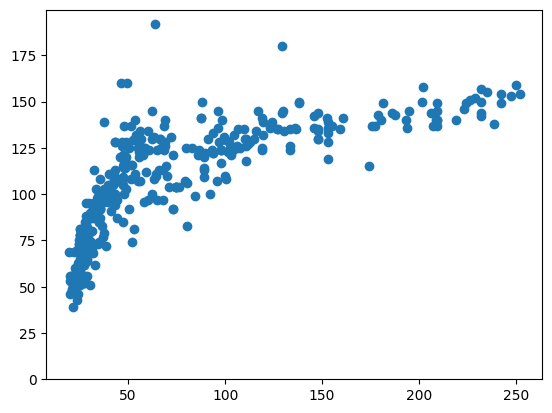

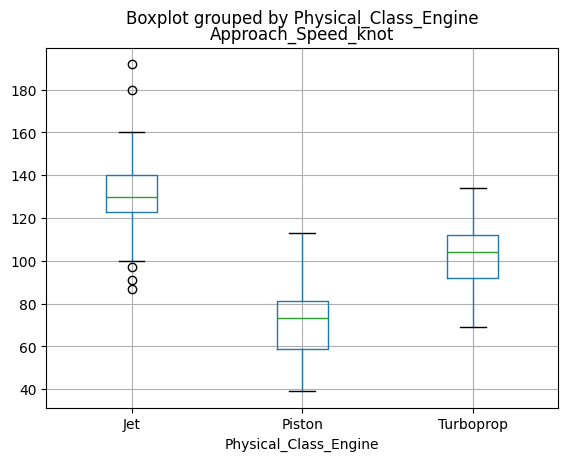

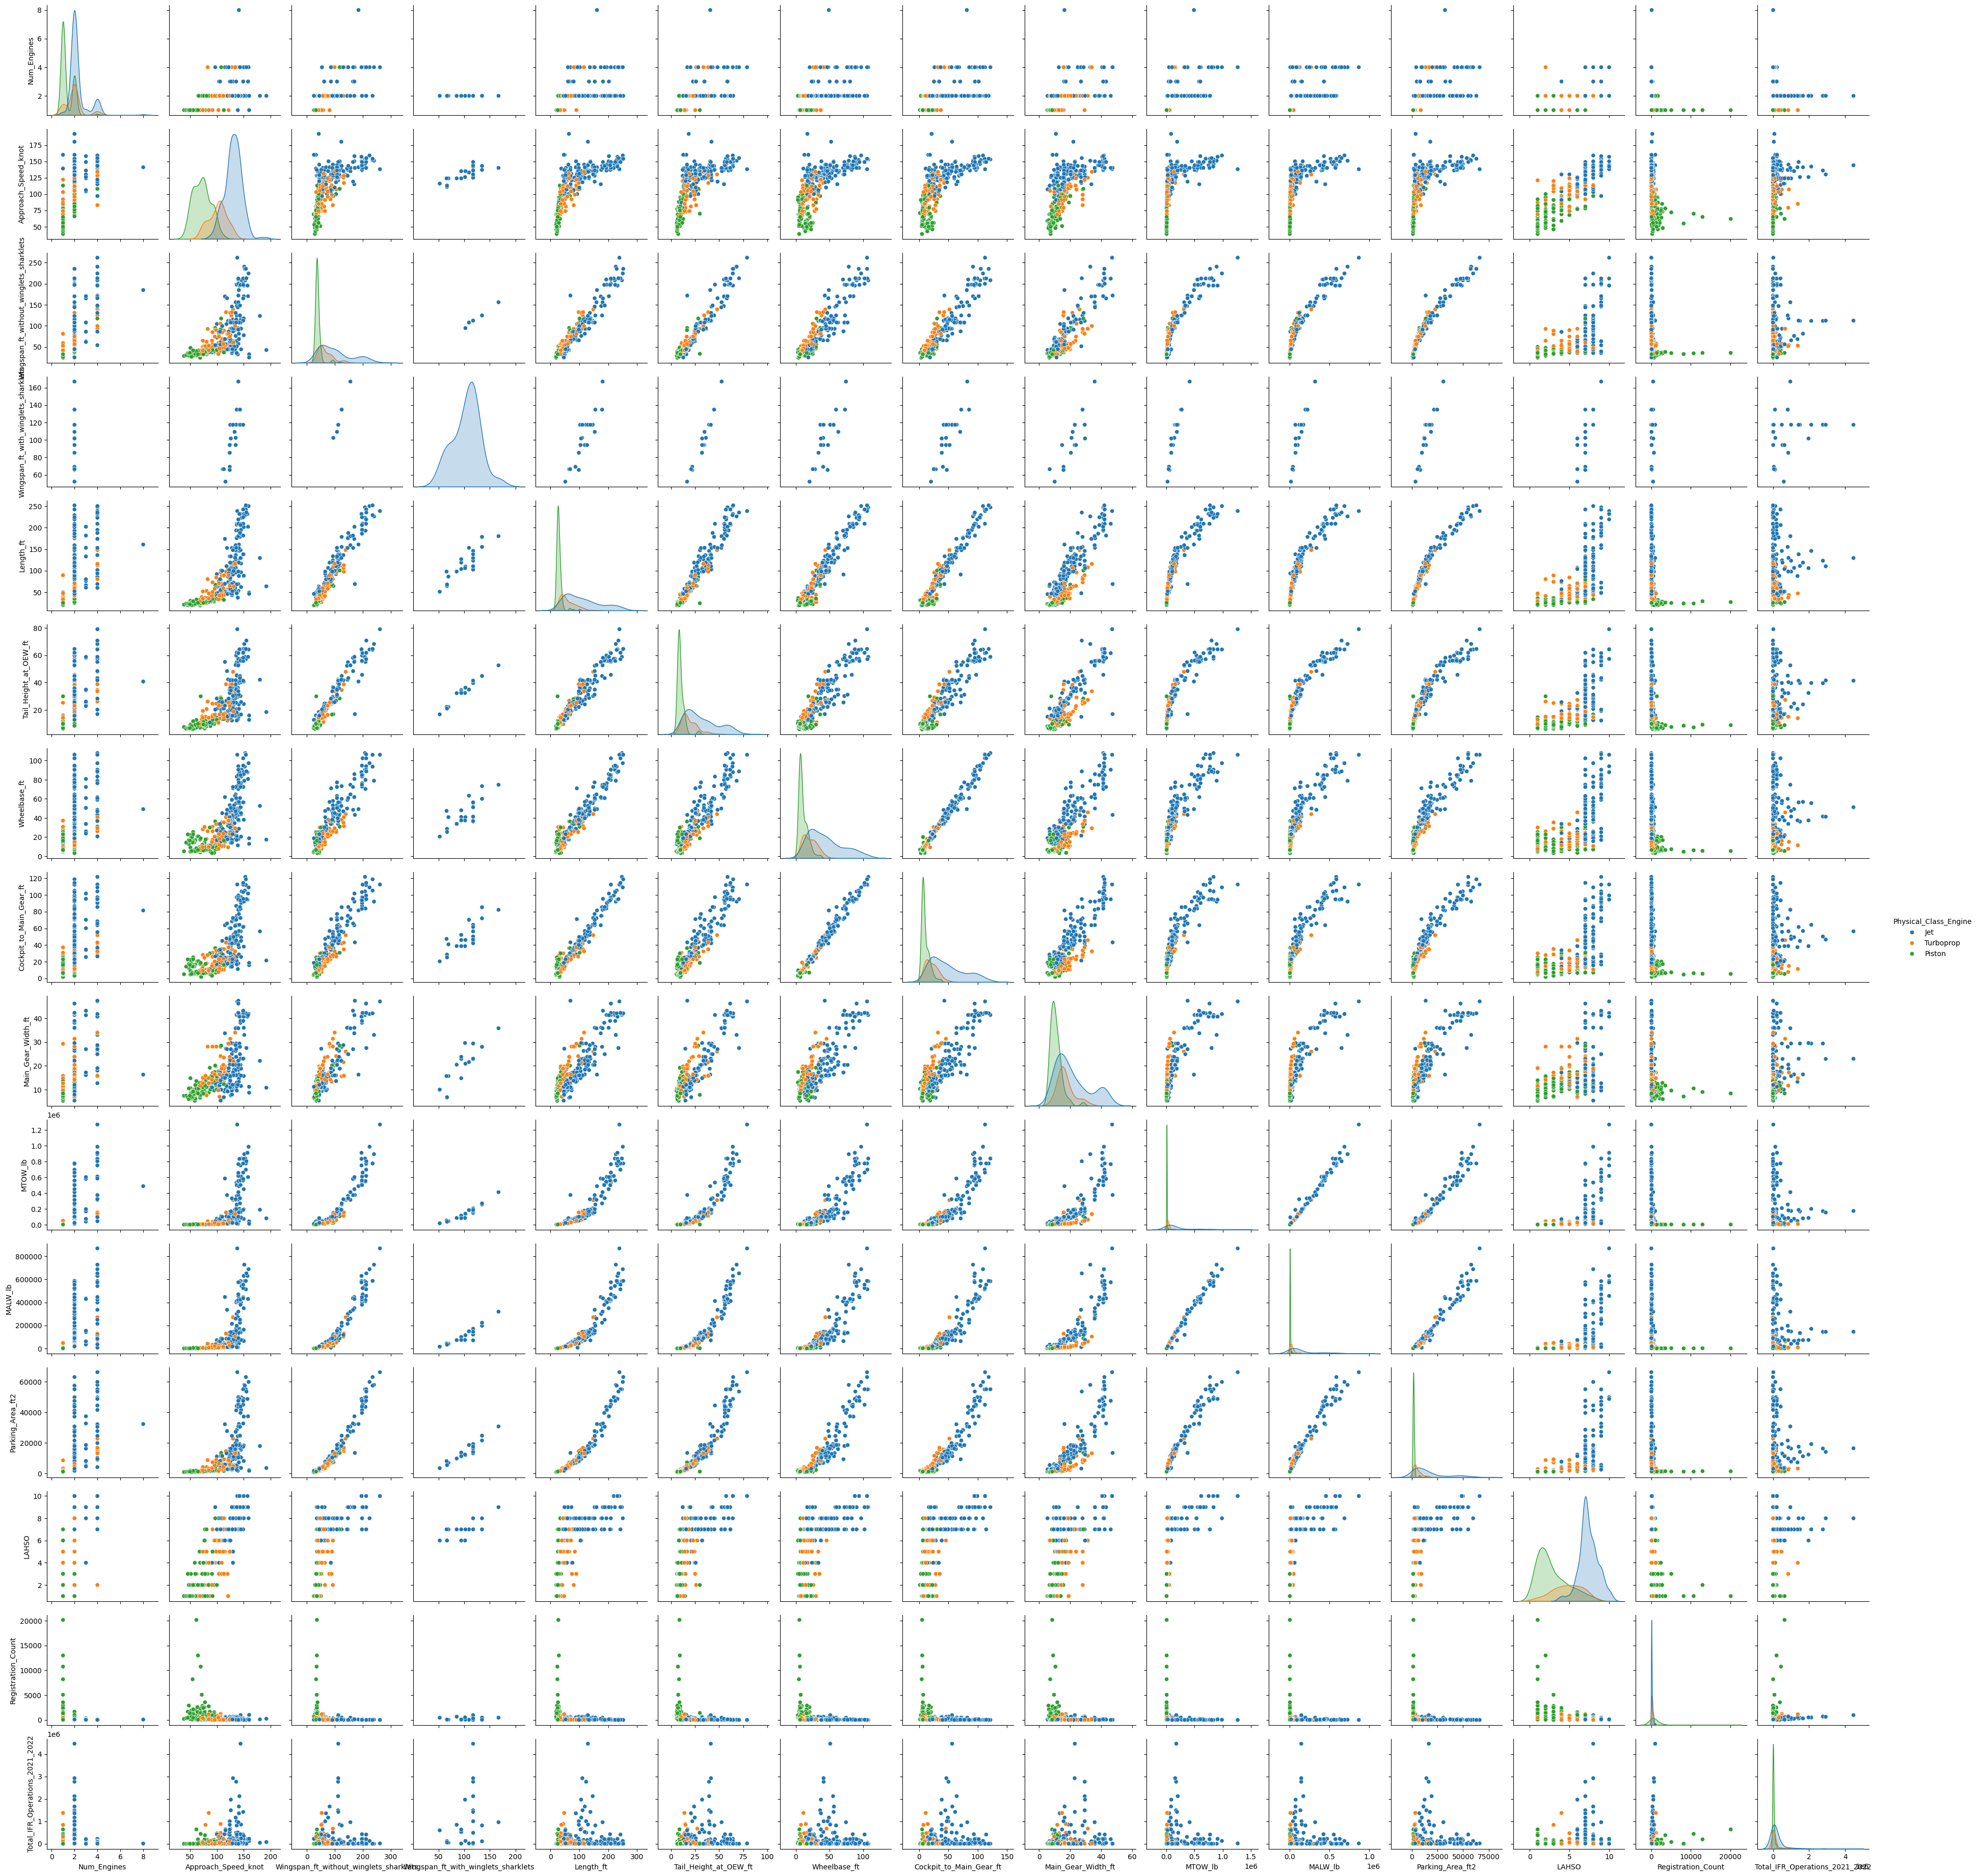

In [9]:
import pandas as pd
import seaborn as sns

df = pd.read_excel('FAA.xlsx')

df.columns

# drop columns containing "Unnamed"
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


# drop AAC_minimum, AAC_maximum, Approach_Speed_minimum_knot, Approach_Speed_maximum_knot
df.drop(['AAC_minimum', 'AAC_maximum', 'Approach_Speed_minimum_knot', 'Approach_Speed_maximum_knot','Rotor_Diameter_ft'], axis=1, inplace=True)

# drop rows where Physical_Class_Engine is Turboshaft
df = df[df['Physical_Class_Engine'] != 'Turboshaft']

df.head()

print(df.columns)

print(df.dtypes)
print(df.info())

# get list of categorical variables
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:{} ".format(object_cols))


# show category counts for Physical_Class_Engine
print(df['Physical_Class_Engine'].value_counts())

# plot length vs approach speed
import matplotlib.pyplot as plt
plt.scatter(df['Length_ft'], df['Approach_Speed_knot'])
plt.ylim(0,)
plt.show()

# do box plot of approach speed by Physical_Class_Engine
df.boxplot(column='Approach_Speed_knot', by='Physical_Class_Engine')
plt.show()

sns.pairplot(df,hue='Physical_Class_Engine')

